**By Muhammad Ilham Adhim** <br>
Submission 1 - NLP Dataset Movies <br>
Data source : https://www.kaggle.com/lokkagle/movie-genre-data

In [1]:
# Read the dataset file by connecting to google drive
from google.colab import drive

# To build dataframe from a file (in this case, csv file)
import pandas as pd

# To create data visualization
import matplotlib.pyplot as plt

# To perform data splitting
from sklearn.model_selection import train_test_split

# To preprocess the text and model creation
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,BatchNormalization

import re

import nltk as nltk
from nltk import corpus

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Dicoding - NLP - Sentiment Analysis /Submission 1/kaggle_movie_train.csv")

# Only get text and genre columns
df = pd.DataFrame(data, columns=["text", "genre"])
df.tail()

,text,genre
22574,n in the world to decide what I'm going to do ...,drama
22575,shards. BOJO LAZ! Laz pushes Deke back through...,drama
22576,"OTTIE You've got a thing about Ernie's, haven'...",thriller
22577,....with marked skill and dexterity . LANA wry...,action
22578,"rd walks off down the hallway, leaving his pos...",comedy


In [3]:
# List some genres that will be excluded
removeGenres = ['drama','thriller','other','adventure','romance']

# Actually remove the rows that contains those genres
df = df[~df['genre'].isin(removeGenres)]
print("===============")
print("Genres distributions : \n{}".format(df['genre'].value_counts()))

Genres distributions : 
comedy    2941
action    2392
sci-fi     613
horror     456
Name: genre, dtype: int64


In [4]:
genre = pd.get_dummies(df.genre)
df_new = pd.concat([df, genre], axis=1)
df_new = df_new.drop(columns='genre')
df_new.head()

,text,action,comedy,horror,sci-fi
1,"t, summa cum laude and all. And I'm about to l...",0,1,0,0
9,e reels as the world spins. Sweat pours off hi...,1,0,0,0
20,I say he's a man who'll go far. Some people s...,0,1,0,0
25,you find out where the bachelor party is? COLE...,0,1,0,0
29,ibly horrendous public break up on the quad. A...,0,1,0,0


In [ ]:
# Check if there is any null value in dataframe
df.isnull().values.any()

False

In [5]:
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
print("\nWords that will be removed from dataframe : {}".format(stopword[:20]))

def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

def split_text(text):
  split=re.split("\W+",text)
  return split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

Words that will be removed from dataframe : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [6]:
df_new['Text_split'] = df_new['text'].map(lambda x: split_text(x.lower()))
df_new['Text_stopword'] = df_new['Text_split'].map(lambda x: remove_stopwords(x))
df_new['Text_stopword']

1        [summa, cum, laude, launch, brand, new, magazi...
9        [e, reels, world, spins, sweat, pours, pressur...
20       [, say, man, go, far, people, say, gone, far, ...
25       [find, bachelor, party, cole, yes, mr, fine, e...
29       [ibly, horrendous, public, break, quad, camero...
                               ...                        
22566    [knew, inhaling, bliss, selina, leans, back, w...
22569    [cricket, running, road, dissolve, 53, ext, ba...
22573    [, well, hello, officer, wydell, holding, badg...
22577    [, marked, skill, dexterity, lana, wryly, surp...
22578    [rd, walks, hallway, leaving, post, end, hallw...
Name: Text_stopword, Length: 6402, dtype: object

In [7]:
df_new

,text,action,comedy,horror,sci-fi,Text_split,Text_stopword
1,"t, summa cum laude and all. And I'm about to l...",0,1,0,0,"[t, summa, cum, laude, and, all, and, i, m, ab...","[summa, cum, laude, launch, brand, new, magazi..."
9,e reels as the world spins. Sweat pours off hi...,1,0,0,0,"[e, reels, as, the, world, spins, sweat, pours...","[e, reels, world, spins, sweat, pours, pressur..."
20,I say he's a man who'll go far. Some people s...,0,1,0,0,"[, i, say, he, s, a, man, who, ll, go, far, so...","[, say, man, go, far, people, say, gone, far, ..."
25,you find out where the bachelor party is? COLE...,0,1,0,0,"[you, find, out, where, the, bachelor, party, ...","[find, bachelor, party, cole, yes, mr, fine, e..."
29,ibly horrendous public break up on the quad. A...,0,1,0,0,"[ibly, horrendous, public, break, up, on, the,...","[ibly, horrendous, public, break, quad, camero..."
...,...,...,...,...,...,...,...
22566,"BUT THEN YOU KNEW THAT. Inhaling some bliss, S...",1,0,0,0,"[but, then, you, knew, that, inhaling, some, b...","[knew, inhaling, bliss, selina, leans, back, w..."
22569,d Cricket running down road. DISSOLVE TO 53. E...,0,0,0,1,"[d, cricket, running, down, road, dissolve, to...","[cricket, running, road, dissolve, 53, ext, ba..."
22573,"Well hello, officer. WYDELL holding up his ba...",0,0,1,0,"[, well, hello, officer, wydell, holding, up, ...","[, well, hello, officer, wydell, holding, badg..."
22577,....with marked skill and dexterity . LANA wry...,1,0,0,0,"[, with, marked, skill, and, dexterity, lana, ...","[, marked, skill, dexterity, lana, wryly, surp..."


In [9]:
# Get all genres from columns and set it as label
columnsGenre = list(df_new.columns)[1:-2]

text = df_new['Text_stopword'].values
label = df_new[columnsGenre].values

In [10]:
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

In [11]:
# Convert to sequences
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train)
tokenizer.fit_on_texts(genre_test)
 
sequence_train = tokenizer.texts_to_sequences(genre_train)
sequence_test = tokenizer.texts_to_sequences(genre_test)
 
padded_train = pad_sequences(sequence_train)
padded_test = pad_sequences(sequence_test)

In [12]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    BatchNormalization(),
    LSTM(64),
    Dropout(0.8),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
# Added callbacks
class handleCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.90):
      print("\nTrain Accuracy and Val_Accuracy is more than 90%!")
      print("\nTraining stopped...")
      self.model.stop_training = True

callbacks = handleCallback()

In [14]:
num_epochs = 30
history = model.fit(padded_train, label_train, 
                    epochs=num_epochs, 
                    validation_data=(padded_test, label_test), 
                    batch_size=32, verbose=2,
                    callbacks=[callbacks])

Epoch 1/30
161/161 - 16s - loss: 1.2333 - accuracy: 0.4497 - val_loss: 1.4280 - val_accuracy: 0.3786
Epoch 2/30
161/161 - 14s - loss: 0.7452 - accuracy: 0.7426 - val_loss: 1.7956 - val_accuracy: 0.1671
Epoch 3/30
161/161 - 13s - loss: 0.4358 - accuracy: 0.8653 - val_loss: 0.6062 - val_accuracy: 0.7767
Epoch 4/30
161/161 - 13s - loss: 0.3566 - accuracy: 0.8819 - val_loss: 0.5295 - val_accuracy: 0.8689
Epoch 5/30
161/161 - 13s - loss: 0.2651 - accuracy: 0.9037 - val_loss: 0.4535 - val_accuracy: 0.8790
Epoch 6/30
161/161 - 13s - loss: 0.2315 - accuracy: 0.9125 - val_loss: 0.5009 - val_accuracy: 0.8774
Epoch 7/30
161/161 - 14s - loss: 0.2025 - accuracy: 0.9162 - val_loss: 0.4398 - val_accuracy: 0.8813
Epoch 8/30
161/161 - 13s - loss: 0.1944 - accuracy: 0.9182 - val_loss: 0.4635 - val_accuracy: 0.8728
Epoch 9/30
161/161 - 13s - loss: 0.1952 - accuracy: 0.9225 - val_loss: 0.4462 - val_accuracy: 0.9001
Epoch 10/30
161/161 - 13s - loss: 0.1564 - accuracy: 0.9539 - val_loss: 0.3867 - val_accura

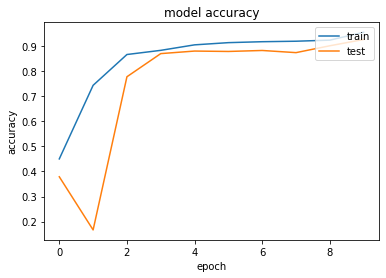

In [15]:
# Create plot for accuracy and val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

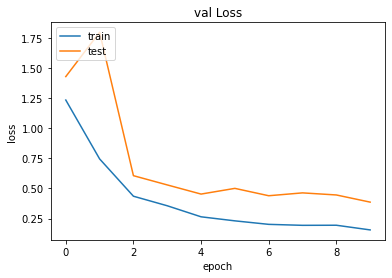

In [16]:
# Create plot for loss and val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('val Loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')
plt.show()